In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.2  # in s
signal_power = 0.0  # in dB
noise_power = 5.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-3e5, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=1)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 0.00 dB
Noise power:  4.98 dB
SNR:          -4.98 dB
Num samples:  200000 


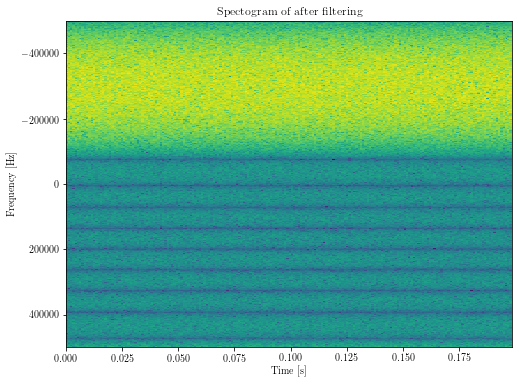

In [21]:
n_taps=16

# apply bandpass filter
noise_fil = ss.filter.fir_bandpass(noise, f_min=-4e5, f_max=-2e5, f_sample=sample_freq, n_taps=n_taps)

# use the 2d plot function to plot the spectogram
ss.spectrum_plot_2d(sig=noise_fil,
                    f_sample=sample_freq,
                    window='flattop',
                    nfft=1024,
                    title='after filtering')

100%|██████████| 199966/199966 [00:01<00:00, 196055.55it/s]


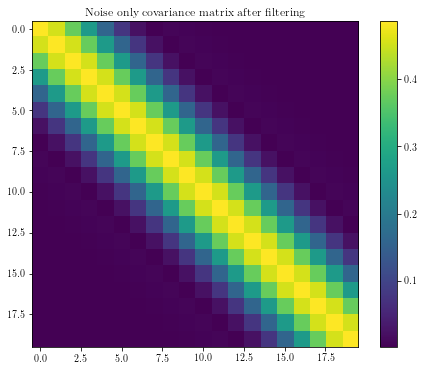

In [5]:
cov_size = 20

plt.figure(figsize=(8, 6))
mat_noise_fil = ss.eigen_detector.corr(x=noise_fil, l=cov_size, prog_bar=True)
plt.imshow(np.abs(mat_noise_fil))
plt.colorbar()
plt.title('Noise only covariance matrix after filtering')
plt.show()

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


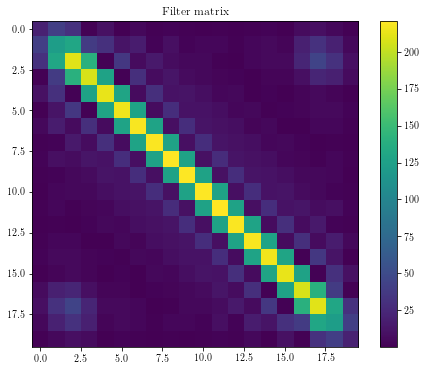

In [9]:
n = 4

w_mats = np.empty((0, cov_size, cov_size))
for i in tqdm.tqdm(range(n)):
    noi = wgn.signal(power=0, dB=True)
    noi_fil = ss.filter.fir_bandpass(noi,
                                     f_min=-4e5,
                                     f_max=-2e5,
                                     f_sample=sample_freq,
                                     n_taps=n_taps)
    w_mat = ss.eigen_detector.whitening_mat(noi_fil, l=cov_size)
    w_mat = np.reshape(w_mat, (1, cov_size, cov_size))
    w_mats = np.append(w_mats, w_mat, axis=0)

w_mat = np.mean(w_mats, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(w_mat))
plt.colorbar()
plt.title('Filter matrix')
plt.show()

In [19]:
# apply bandpass filter to noise
noise = wgn.signal(power=noise_power, dB=True)
noi_fil = ss.filter.fir_bandpass(noi,
                                 f_min=-4e5,
                                 f_max=-2e5,
                                 f_sample=sample_freq,
                                 n_taps=n_taps)

# check what the stats have to say
pfa = 0.01
thr = ss.eigen_stats.mme_thr(Ns=num_samples, L=cov_size, Pfa=pfa)
eng_noise = ss.eigen_detector.mme(x=noise, l=cov_size)
eng_noise_fil = ss.eigen_detector.mme(x=noi_fil, l=cov_size, w_mat=w_mat)
raw_noise_fil = ss.eigen_detector.mme(x=noi_fil, l=cov_size)

print('Prob false alarm:   %.4f' % (pfa))
print('Threshold:          %.4f' % (thr))
print('Noise only mme:     %.4f' % (eng_noise))
print('Filtered noise mme: %.4f' % (eng_noise_fil))
print('Raw Filtered   mme: %.4f' % (raw_noise_fil))

Prob false alarm:   0.0100
Threshold:          1.0437
Noise only mme:     1.0270
Filtered noise mme: 1.0374
Raw Filtered   mme: 231909.3947


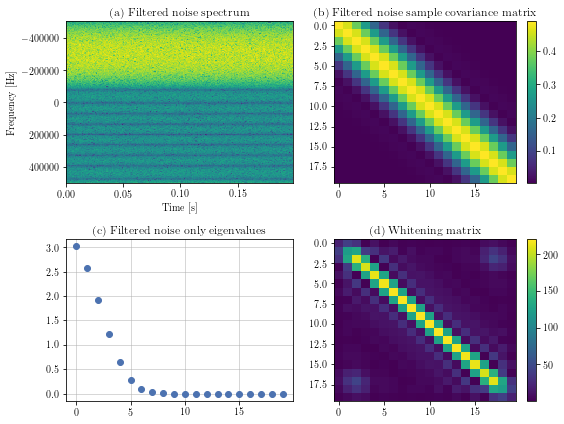

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(noise_fil, sample_freq, normalized=True, dB=True)
axs[0, 0].pcolormesh(t,
               f,
               x,
               cmap='viridis',
               vmin=np.min(x),
               vmax=np.max(x))
axs[0, 0].set_xlabel(r'Time [s]')
axs[0, 0].set_ylabel(r'Frequency [Hz]')
axs[0, 0].set_title(r'(a) Filtered noise spectrum')
axs[0, 0].invert_yaxis()

mat_noise = ss.eigen_detector.corr(x=noise_fil, l=cov_size)
axs[0, 1].set_title(r'(b) Filtered noise sample covariance matrix')
img = axs[0, 1].imshow(np.abs(mat_noise), aspect='auto')
cbar = plt.colorbar(img, ax=axs[0, 1])
# cbar.set_label(r'Amplitude')

noise_eigvals = np.abs(linalg.eigvals(mat_noise))
axs[1, 0].plot(noise_eigvals, 'o', alpha=1., aa=True)
axs[1, 0].set_title(r'(c) Filtered noise only eigenvalues')
axs[1, 0].grid(linewidth=0.5)

axs[1, 1].set_title(r'(d) Whitening matrix')
img = axs[1, 1].imshow(np.abs(w_mat), aspect='auto')
cbar = plt.colorbar(img, ax=axs[1, 1])
# cbar.set_label(r'Amplitude')

plt.tight_layout()
plt.savefig('out/chap5/eigenvalue_whitening.pdf')